In [1]:
import os 
os.chdir("/Users/fw23aao/brewsteretrieval/brewster_v1")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import matplotlib.colors as colors
import scipy as sp
import numpy as np
import emcee
import os 
from collections import namedtuple
import settings
import utils
import test_module
import retrieval_run
import corner
import pickle as pickle
import TPmod
import brewtools
from IPython.display import display
import gas_nonuniform
%matplotlib inline

In [2]:
path = "/Users/fw23aao/spidernail/browndwarf_retrieval/sim0136/"

runname = "v2_Eti0136_deckdpprior_input_I2" 

# OK finish? 1 for yes, 0 for no.
fin = 0
flatendchain, flatendprobs,ndim = brewtools.get_endchain(runname,fin,path)
theta_max_end = flatendchain[np.argmax(flatendprobs)]
max_end_like = np.amax(flatendprobs)
samples = flatendchain

argfile =path+runname+"_runargs.pic"
runargs = brewtools.pickle_load(argfile)
settings.init(runargs)


with open(path+runname+'_configs.pkl', 'rb') as file:
    configs= pickle.load(file)
    
re_params=configs['re_params']
model_config_instance=configs['model_config']

BIC = (-2.* max_end_like) + (ndim*np.log(runargs.obspec.shape[1]))
print("BIC = "+str(BIC))

Unfinished symphony. Number of successful iterations =  22000
maximum likelihood =  64053.416964931304
maximum likelihood in final 2K iterations=  64053.416964931304
BIC = -127903.4097650532


In [3]:
all_params,all_params_values =utils.get_all_parametres(re_params.dictionary) 
params_master = namedtuple('params',all_params)
params_instance = params_master(*theta_max_end)

In [4]:
params_instance

params(h2o=-3.814750857479858, co=-3.3556610691356332, co2=-6.814758001511325, ch4=-4.311261946727821, nh3=-5.227831987253999, crh=-9.335842311679876, feh=-9.281855471662372, K_Na=-6.502300041948745, logg=4.9852951900776485, r2d2=2.518137461448841e-19, dlambda=-0.0011660134580285223, tolerance_parameter_1=-30.98877653095547, alpha1=0.9745863665081602, alpha2=0.03303072893679525, logP1=0.6002830372270253, logP3=1.3853336519721713, T3=3955.59690039794, fcld=0.9450734674044413, tau_mcs_Mg2SiO4=34.13468835894494, logp_mcs_Mg2SiO4=0.2350739902541944, dp_mcs_Mg2SiO4=0.45145833850859535, hansan_a_mcs_Mg2SiO4=-1.031827533065082, hansan_b_mcs_Mg2SiO4=0.3623910846739204, logp_mcd_Fe=1.1002239038772115, dp_mcd_Fe=0.14439575360536092, hansan_a_mcd_Fe=-0.9037187003172575, hansan_b_mcd_Fe=0.1132675679005001)

In [5]:
intemp_keys = list(re_params.dictionary['pt']['params'].keys())

if runargs.proftype==1 or runargs.proftype==77:
    p_index_first=params_instance._fields.index(intemp_keys[1]) 
else:
    p_index_first=params_instance._fields.index(intemp_keys[0]) 
    
p_index_last=params_instance._fields.index(intemp_keys[-1])+1

Tsamples = samples[:,p_index_first:p_index_last]


nsamps = Tsamples.shape[0]
Tprofs = np.empty([64,Tsamples.shape[0]])
for i in range(0,nsamps):
    Tprofs[:,i] = TPmod.set_prof(runargs.proftype,runargs.coarsePress,runargs.press,Tsamples[i,:])
    
Tlays = np.empty([64,5])
for i in range(0,64):
    junk = Tprofs[i,:]
    junk2 = np.percentile(junk, [2.4,16, 50, 84,97.6],axis=0)
    junk3 = np.array(junk2)
    Tlays[i,:] = junk3[:]

In [6]:
cloudlist_slab=list(re_params.dictionary["cloud"]["patch 1"]['Mie scattering cloud slab--Mg2SiO4']['params'])

cloudlist_deck=list(re_params.dictionary["cloud"]["patch 1"]['Mie scattering cloud deck--Fe']['params'])

In [7]:
# get the cloud stuff
cloudsamples_deck = samples[:,params_instance._fields.index(cloudlist_deck[0]):params_instance._fields.index(cloudlist_deck[-1])+1]
cloud_Top_deck  = np.percentile(cloudsamples_deck [:, 0], [16, 50, 84])
cloud_height_deck  = np.percentile(cloudsamples_deck [:, 1], [16, 50, 84])


cloudtemp_slab = samples[:,params_instance._fields.index(cloudlist_slab[0]):params_instance._fields.index(cloudlist_slab[-1])+1]
cloudsamples_slab = np.empty_like(cloudtemp_slab)
print(cloudtemp_slab.shape)
cloudsamples_slab[:,0] = cloudtemp_slab[:,0]
cloudsamples_slab[:,1] = cloudtemp_slab[:,1] + cloudtemp_slab[:,2]
cloudsamples_slab[:,2] = cloudtemp_slab[:,2]
cloudsamples_slab[:,3] = cloudtemp_slab[:,3]
cloudsamples_slab[:,4] = cloudtemp_slab[:,4]

cloud_Base_slab = np.percentile(cloudsamples_slab[:, 1], [16, 50, 84])
cloud_height_slab = np.percentile(cloudsamples_slab[:, 2], [16, 50, 84])
cloud_Tau_slab = np.percentile(cloudsamples_slab[:, 0], [16, 50, 84])

(864000, 5)


cloud_tau = 28.75, 30.72, 32.37


/var/folders/sr/r1_2x6s53hz6yjfb9f4xkq7m0000gr/T/ipykernel_64612/3507204944.py:73: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x324157050> starts with '_'. It is thus excluded from the legend.
  prf.legend(handles=[d1,c1,c2,c3,c4,c5,c6],prop={'size':8})
/var/folders/sr/r1_2x6s53hz6yjfb9f4xkq7m0000gr/T/ipykernel_64612/3507204944.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


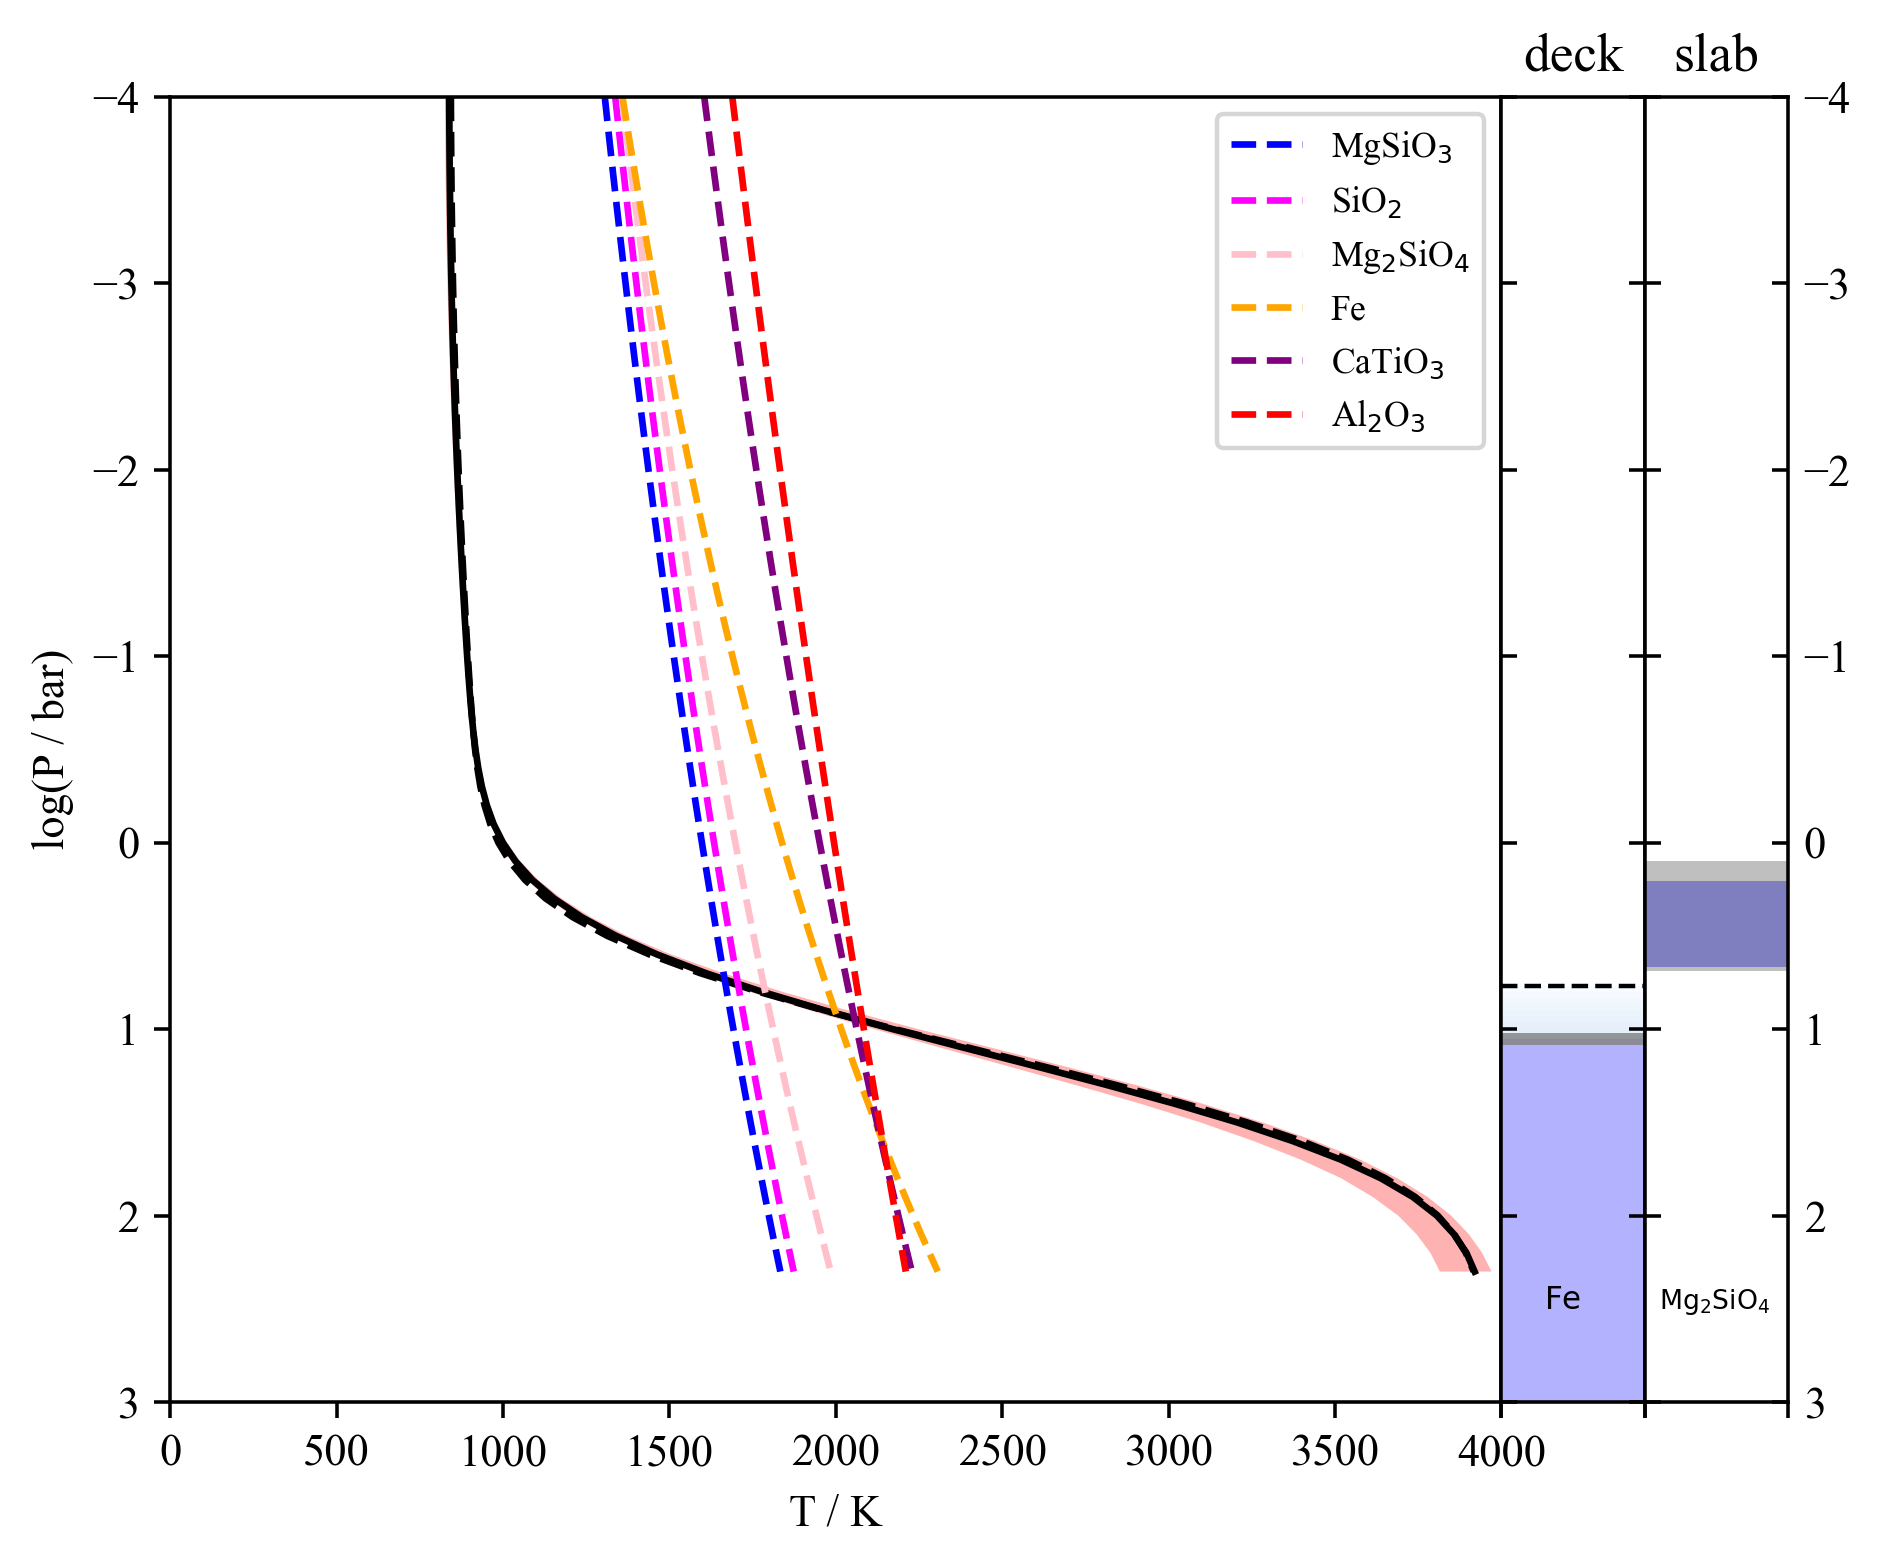

In [8]:
# This may need tweaking - it is untested. 
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)

prf = fig.add_axes([0.1, 0.1, 0.65, 0.85])

prf.axis([0., 4000.,3.0,-4.0])
plt.ylabel(r'log(P / bar)')
plt.xlabel('T / K')

cld1 = fig.add_axes([0.75,0.1,0.07,0.85],xticklabels=[],xlim=[0,1])
cld1.axis([0,1,3,-4])
cld1.tick_params(axis='y',direction='in',left=True,right=True,labelleft=False,labelright=False)

BesTprof = TPmod.set_prof(runargs.proftype,runargs.coarsePress,runargs.press,theta_max_end[p_index_first:p_index_last])


npts = 10

cmap = mpl.cm.Blues
y = np.linspace(cloud_Top_deck[1] - cloud_height_deck[1],cloud_Top_deck[1],npts)
normalize = mpl.colors.Normalize(vmin=y.min(), vmax=y.max()+2)
for j in range(0,npts-1):
        cld1.fill_between([0.,1.],y[j],y[j+1],facecolor=cmap(normalize(y[j])), linewidth=0.0)
        
cld1.fill_between([0.,1.],3.0,cloud_Top_deck[1],facecolor='blue',alpha=0.3)
cld1.fill_between([0,1.],cloud_Top_deck[2],cloud_Top_deck[0],facecolor='grey',alpha=0.8)
cld1.plot([0,1],[cloud_Top_deck[1] -cloud_height_deck[1],cloud_Top_deck[1] - cloud_height_deck[1]],'k--',linewidth=1.0)
cld1.set_title("deck")
cld1.text(0.3,2.5,r"$\rm Fe$",fontsize=7)


cld2 = fig.add_axes([0.82,0.1,0.07,0.85],xticklabels=[],xlim=[0,1])
cld2.axis([0,1,3,-4])
cld2.tick_params(axis='y',direction='in',left=True,right=True,labelleft=False,labelright=True)

cld2.fill_between([0,1.],cloud_Base_slab[1],cloud_Base_slab[1] - cloud_height_slab[1],facecolor='blue',alpha=0.5)
cld2.fill_between([0,1.],cloud_Base_slab[2],cloud_Base_slab[1] - cloud_height_slab[2],facecolor='grey',alpha=0.5)
cld2.set_title("slab")
cld2.text(0.10,2.5,r"$\rm Mg_{2}SiO_{4}$",fontsize=6)




logP = np.log10(runargs.press)
d1, = prf.plot(Tlays[:,2],logP,'k-')
prf.fill_betweenx(logP,Tlays[:,1], Tlays[:,3], facecolor='red', alpha=0.3)
# prf.fill_betweenx(logP,Tlays[:,0], Tlays[:,4], facecolor='red', alpha=0.1)


prf.plot(BesTprof ,logP,'k--')


pero = 10.0**4 / (5.125 - 0.277*logP - 0.554*0.0)

qtz = 10.0**4 / (6.12 - 0.34*logP - 0.69*0.0)
qtz_alt = 10.0**4 / (6.27 - 0.34*logP - 0.69*0.0)


enst = 10.0**4/(6.26 - 0.35*logP-0.70*0.0)
fost = 10.0**4/(5.89 - 0.37*logP-0.73*0.0)
iron = 10.0**4/(5.44 - 0.48*logP-0.48*0.0)
cr =  10.0**4/(6.528 - 0.491*logP-0.491*0.0)
al2o3 = 10.0**4 / (5.0139 - 0.21794*(logP) + 2.2636E-03*(logP)**2.0 - 0.580*0.0)

c1, = prf.plot(enst,logP,'--',color='blue',linewidth=1.5, label='MgSiO$_3$')
c2, = prf.plot(qtz,logP,'--',color='magenta',linewidth=1.5, label='SiO$_2$')
c3, = prf.plot(fost,logP,'--',color='pink',linewidth=1.5,label='Mg$_2$SiO$_4$')
c4, = prf.plot(iron,logP,'--',color='orange',linewidth=1.5, label='Fe')
c5, = prf.plot(pero,logP,'--',color='purple',linewidth=1.5, label='CaTiO$_3$')
c6, = prf.plot(al2o3,logP,'--',color='red',linewidth=1.5, label='Al$_2$O$_3$')

prf.legend(handles=[d1,c1,c2,c3,c4,c5,c6],prop={'size':8}) 


#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
# plt.savefig(runname+"_profile.png",format='png', dpi=320)
s = 'cloud_tau = '+str(round(cloud_Tau_slab[0],2))+', '+str(round(cloud_Tau_slab[1],2))+', '+str(round(cloud_Tau_slab[2],2))
print(s)

plt.tight_layout()
plt.show()

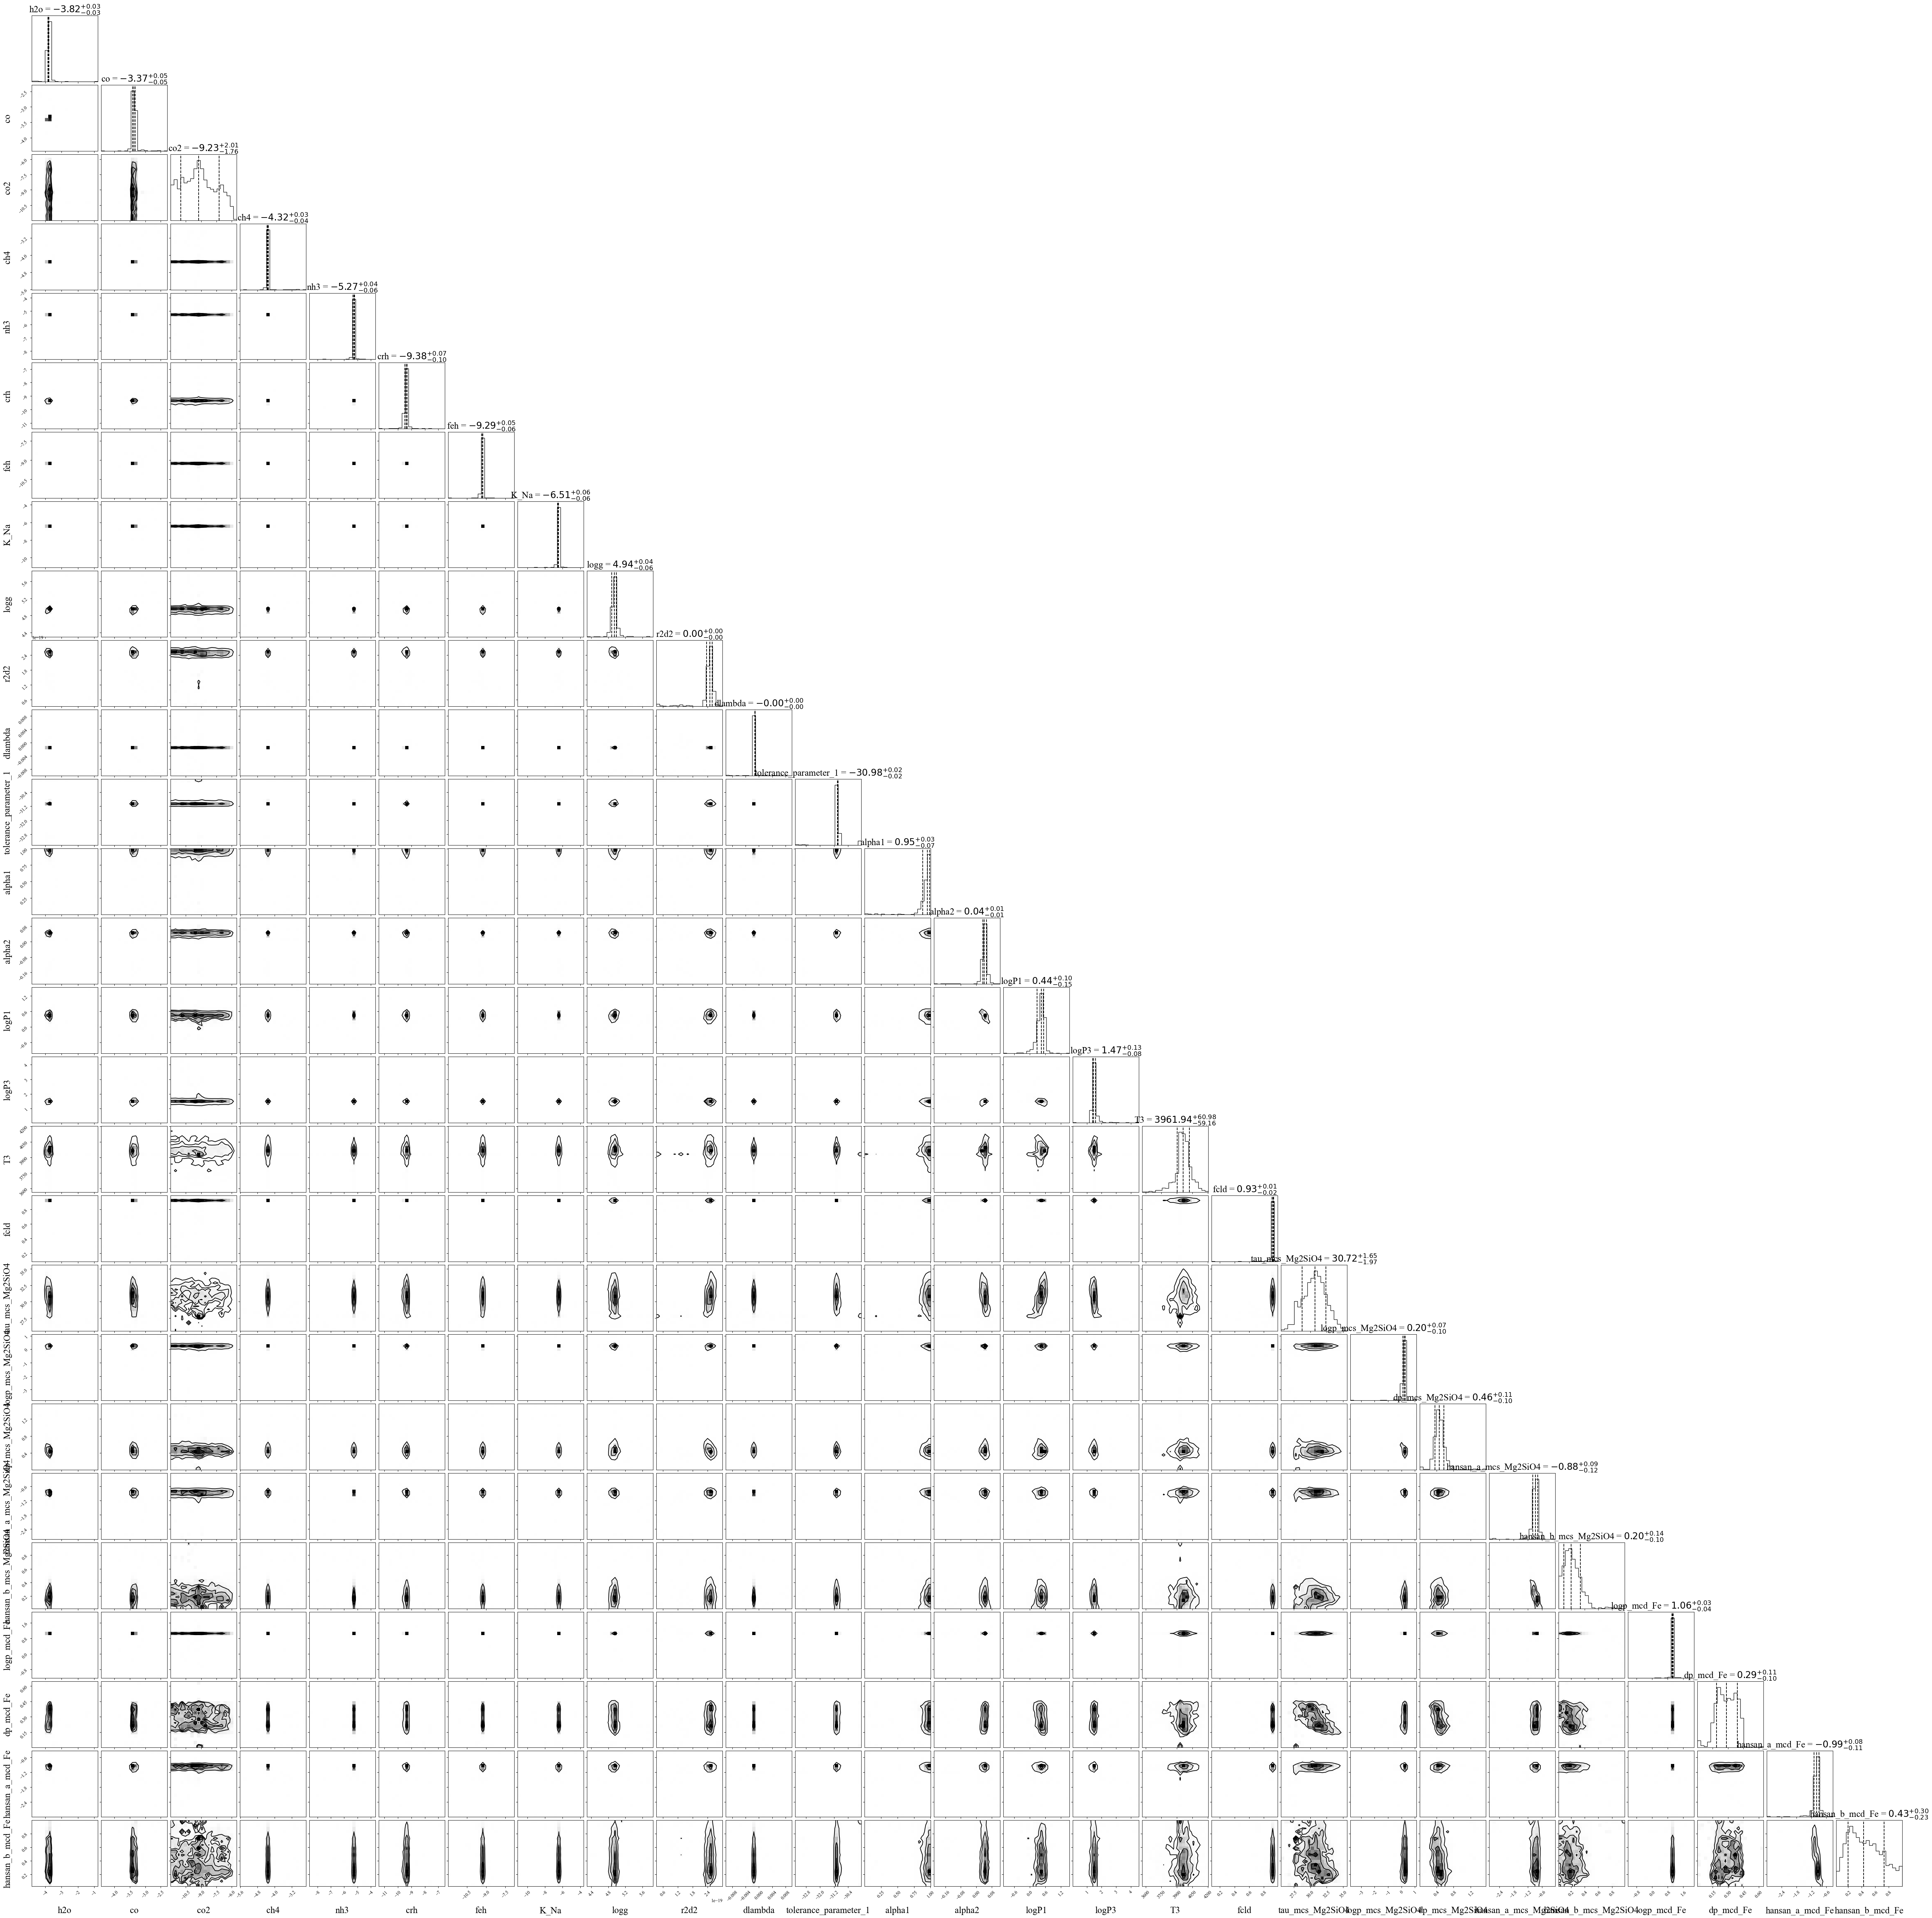

In [9]:
fig = corner.corner(samples,scale_hist=False,plot_datapoints =False,\
                    labels=all_params,\
                    quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 20},\
                    label_kwargs={"fontsize": 20})

In [10]:
# get diagnostics along with the spectrum
gnostics = 0
# Now run the model again to get your model spectrum and process to make it look like the data
shiftspec, photspec, tauspec,cfunc = test_module.modelspec(theta_max_end,re_params,runargs,gnostics)
topspec = brewtools.proc_spec(shiftspec,theta_max_end,runargs.fwhm,runargs.chemeq,runargs.gasnum,runargs.obspec) 

In [11]:
# Now grab 500 random draws from the posterior
pltspec = np.zeros((500,runargs.obspec[0,:].size))
samp= np.empty(ndim)
samples = flatendchain
sid = np.zeros(500)
for i in range (0,500):
    sid[i]= np.random.randint(0,high = len(samples))
    samp = samples[int(sid[i]),:]
    
    shiftspec, photspec, tauspec,cfunc = test_module.modelspec(samp,re_params,runargs,gnostics)
    pltspec[i,:] = brewtools.proc_spec(shiftspec,samp,runargs.fwhm,runargs.chemeq,runargs.gasnum,runargs.obspec) 

# get the intervals for the distribution of model spectra
specdist = np.empty([runargs.obspec[0].size,5])
for i in range(0,runargs.obspec[0].size):
    junk = pltspec[:,i]
    junk2 = np.percentile(junk, [2.4,16, 50, 84,97.6],axis=0)
    junk3 = np.array(junk2)
    specdist[i,:] = junk3[:]

Text(0.5, 0, 'Wavelength / $\\mu m$')

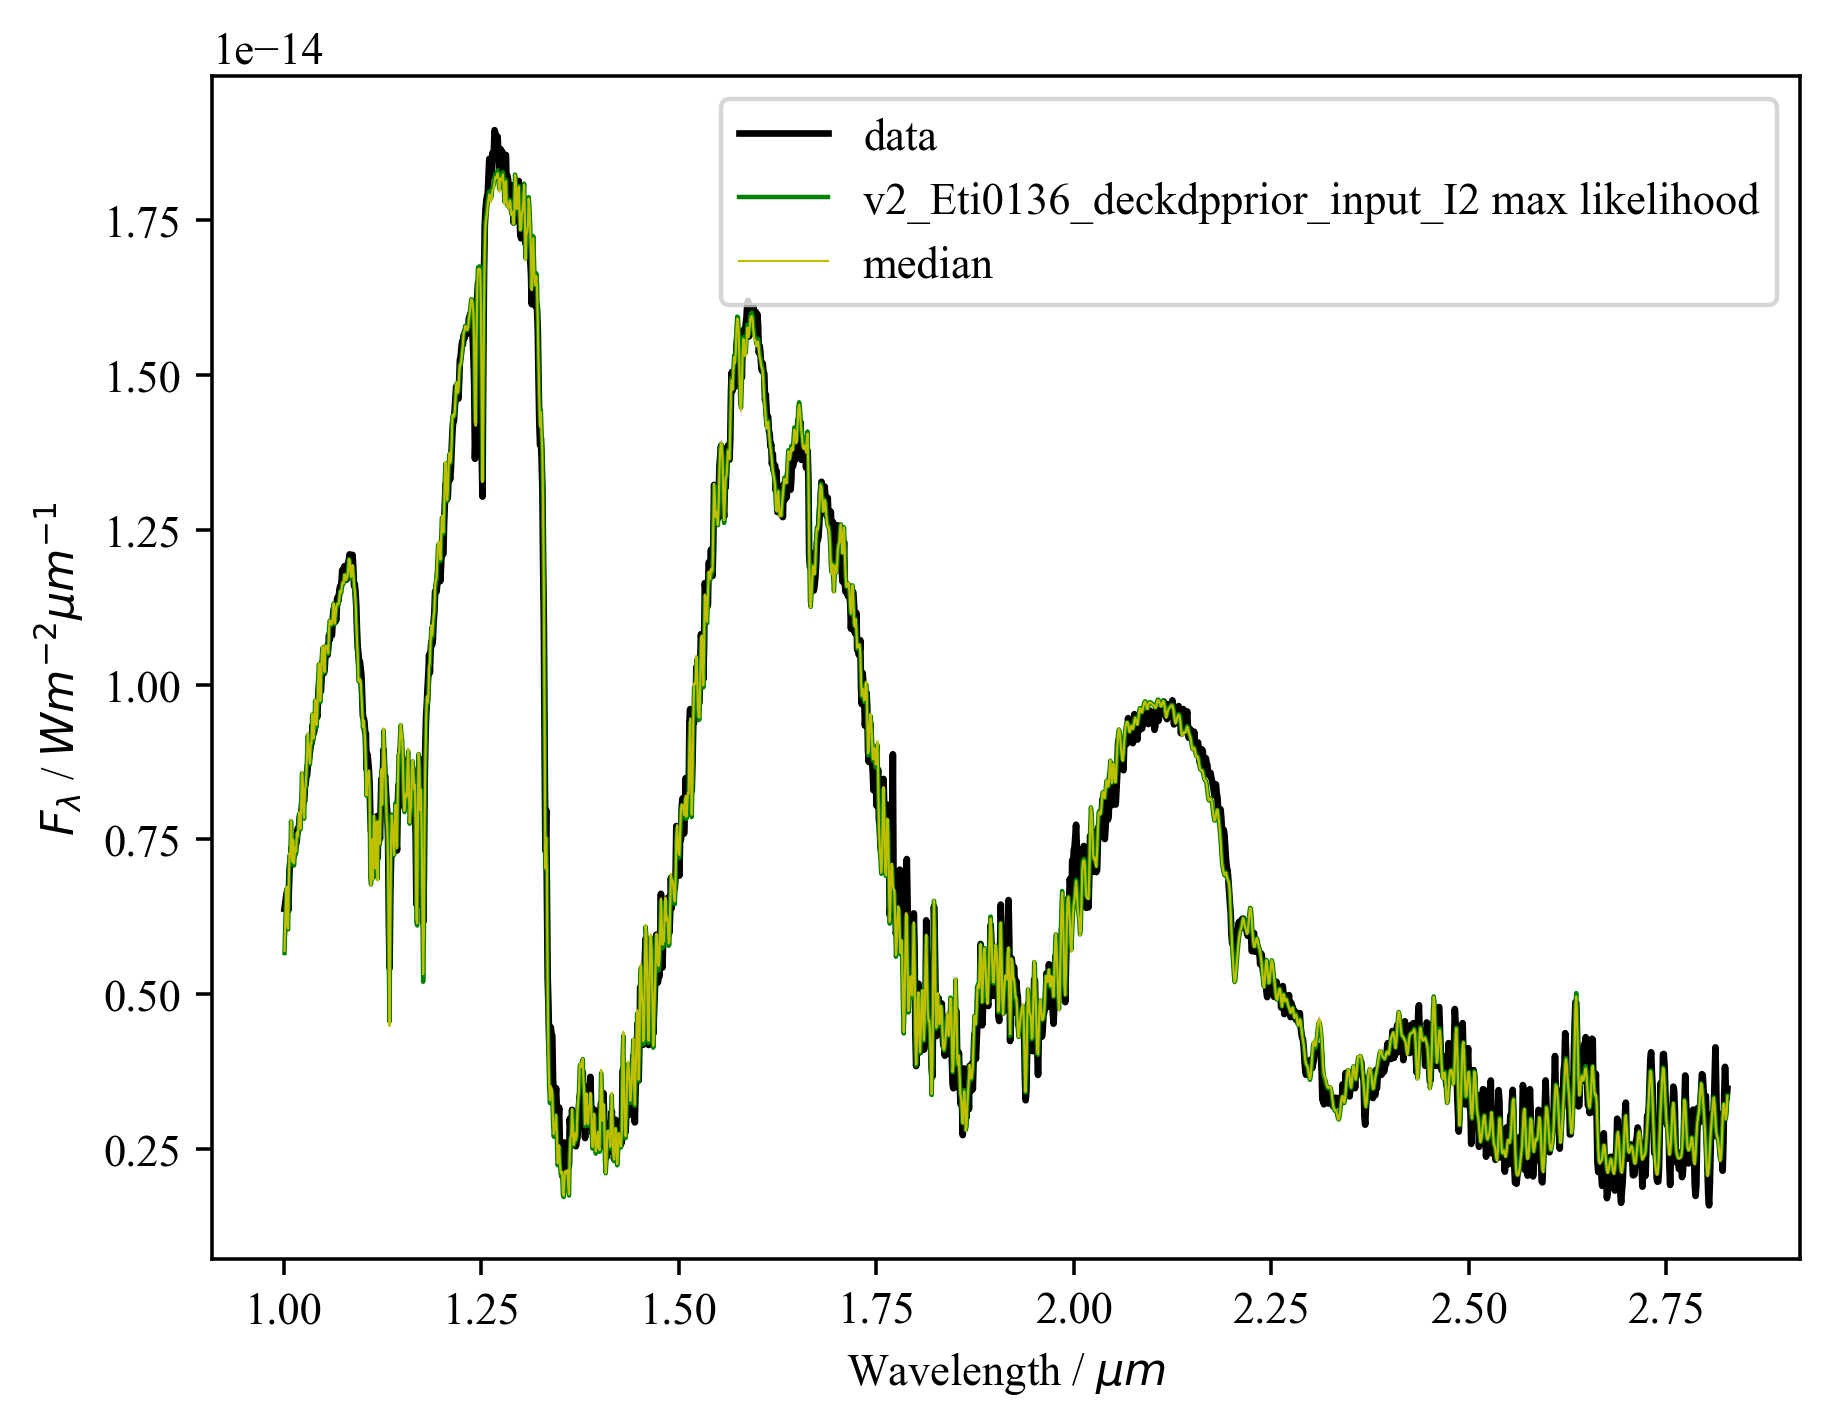

In [12]:
# plot the spectra
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)


d1, = plt.plot(runargs.obspec[0,:],runargs.obspec[1,:],'k-',label = "data")
t1, = plt.plot(runargs.obspec[0,:],topspec,'g-',linewidth=1, label = runname+" max likelihood")

r1, = plt.plot(runargs.obspec[0],specdist[:,2],'y-',linewidth=0.5, label = "median")
#plt.fill_between(obspec[0],specdist[:,0],specdist[:,4],facecolor='red',alpha=0.2)
plt.fill_between(runargs.obspec[0],specdist[:,1],specdist[:,3],facecolor='red',alpha=0.5)
#plt.fill_between(obspec[0,:],obspec[1,:]-obspec[2,:],obspec[1,:]+obspec[2,:],facecolor='red',alpha=0.2)


plt.legend(handles=[d1,t1,r1])


plt.ylabel(r'$ F_{\lambda}$ / $Wm^{-2} \mu m^{-1}$')
plt.xlabel('Wavelength / $\mu m$')
#plt.savefig(runname+"_SPAG_SPEC.png",format='png', dpi=320))